In [14]:
# General libraries for easy data manipulation
import os  
import math
import random
import numpy as np
import pandas as pd
# Scientific computing libraries
import scipy as scp
import astropy.constants as asc
# Plotting libraries and methods
import matplotlib.pyplot as plt
from mpmath import *
#<< Import more libraries as needed >>


In [15]:
nv = 4194304#number of voltage samples to plot time series
hb = 200#number of bins for histogram
n = 2**(12) #Number of time bins we are selecting per each FFT
dt = 2.5/(10**9) # Time resolution of 1/(33 MHz) seconds
fmax = 200000000 # Equals the bandwidth upper-limit of 16.5 MHz
Nt = int(nint(4194304/n))#Number of time bins in dynamic spectrum
tt = 4194304*dt#total time
ts = 4194304#total samples
Nf =  int(nint(n*dt*fmax)) # Number of frequency bins; Choose a power of 2: 2^n (E.g., 64, 128, 256)
Tmax =  Nf/fmax # Largest time-scale of variability probed is the inverse of the lowest frequency of interest
df =  fmax/Nf# Lowest frequency probed is equal to the chosen frequency resolution (Bandwidth by number of frequency bins)
Nfft =  int(Tmax/dt) # Number of voltage samples to obtain FFT is the number of voltage samples that span the largest time-scale of interest
Nspectra = n # The spectral time series has a factor of 'Nfft' less time bins than the voltage data
volts1 = pd.read_csv('C11_1024_Packets_B3.out', delim_whitespace=True, header=None)
volts2 = pd.read_csv('C12_1024_Packets_B3.out', delim_whitespace=True, header=None)
vl1 = volts1.iloc[:,0]
vl2 = volts2.iloc[:,0]

#Time array (seconds)
x = np.zeros(nv)
for i in range(nv):
    x[i]=(i/(400*1000000))

In [16]:
#C11
y1 = np.array(vl1.values.tolist())#Voltage data
p1 = np.square(y1)#Power data
vy1 = y1[0:nv]
py1 = np.square(vy1)
m1 = np.mean(y1)#Mean
s1 = np.std(y1)#Standard deviation
y1 = y1 - m1#Correcting offset
a1 = np.reshape(y1,(Nt,Nfft))#2D array for input of fourier transform
ff1 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform


#C12
y2 = np.array(vl2.values.tolist())#voltage data
p2 = np.square(y2)#power data
vy2 = y2[0:nv]
py2 = np.square(vy2)
m2 = np.mean(y2)#Mean
s2 = np.std(y2)#Standard deviation
y2 = y2 - m2#Correcting offset
a2 = np.reshape(y2,(Nt,Nfft))#2D array for input of fourier transform
ff2 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Cross correlation (C11 & C12)
ffc = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Showing means and standard deviations
print("Mean for North Antenna:",m1)
print("Mean for South Antenna:",m2)
print("Standard deviation for North Antenna:",s1)
print("Standard deviation for South Antenna:",s2)

#Gaussian and exponential fit for histograms
xv = np.linspace(-100,100,num=hb)#voltage array
xv2 = np.linspace(0,10000,num=hb)#power array
z1 = (np.exp((-(xv)**2)/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1)#Gaussian fit for PD for north antenna
z2 = (np.exp((-(xv)**2)/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2)#Gaussian fit for PD for south antenna
w1 = (np.exp((-(xv2))/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1*(np.sqrt(xv2)))#Exponential fit for PD for north antenna
w2 = (np.exp((-(xv2))/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2*(np.sqrt(xv2)))#Exponential fit for PD for south antenna



Mean for North Antenna: -1.0569393634796143
Mean for South Antenna: -1.058096170425415
Standard deviation for North Antenna: 21.385557014213084
Standard deviation for South Antenna: 21.462586466437152


C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide


In [17]:
#Fourier Transform
for i in range(Nt):
    ft1 = np.fft.rfft(a1[i])#Fourier Transform (C11)
    ft2 = np.fft.rfft(a2[i])#Fourier Transform (C12)
    fts1 = ft1[1:np.shape(ft1)[0]]#Eliminating the zero frequency (C11)
    fts2 = ft2[1:np.shape(ft2)[0]]#Eliminating the zero frequency (C12)
    ff1[i]=np.abs(fts1)/n#Auto Correlation (C11)
    ff2[i]=np.abs(fts2)/n#Auto Correlation (C12)
    
    #Cross correlation
    o = np.conjugate(fts1)#Complex conjugate (C12)
    ftc = np.multiply(o,fts2)#Cross correlation (C11 & C12)
    ffc[i]=np.abs(ftc)/n#Taking magnitude
    
fft1 = np.transpose(ff1)
fft2 = np.transpose(ff2)
fftc = np.transpose(ffc)
#Averaging over time_res channels
time_res = 60#Number of time bins to be averaged
xt = int((np.shape(ff1)[0])/time_res)
yt = int(np.shape(ff1)[1])
ftf1 = np.zeros((xt,yt))#2D zero array for output (C11)
ftf2 = np.zeros((xt,yt))#2D zero array for output (C12)
ftfc = np.zeros((xt,yt))#2D zero array for real output (C11 & C12 cross correlation)
for i in range(xt):
    b1 = 0
    b2 = 0
    bc = 0
    for j in range(time_res):
        b1 = b1+ff1[j+(i*time_res)]
        b2 = b2+ff2[j+(i*time_res)]
        bc = bc+ffc[j+(i*time_res)]
    c1 = b1/time_res
    c2 = b2/time_res
    cc = bc/time_res
    ftf1[i]=c1
    ftf2[i]=c2
    ftfc[i]=cc
    
#Interchanging the axes
#ftr1 = ftf1[::-1]
#ftr2 = ftf2[::-1]
#ftrc = ftfc[::-1]
fftt1 = np.transpose(ftf1)
fftt2 = np.transpose(ftf2)
ffttc = np.transpose(ftfc)

xd = np.linspace(0,tt,num=int(Nt/time_res))
yd = np.linspace(0,Nf,num=Nf)

C:\Users\parvp\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


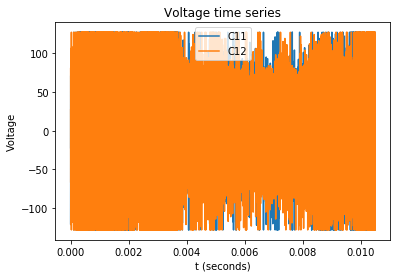

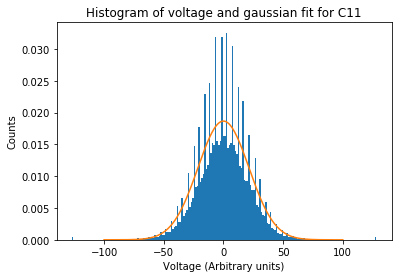

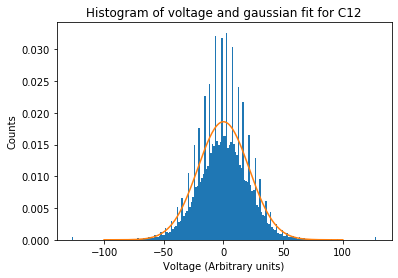

In [18]:
#Voltage series plot
plt.figure(0)
plt.plot(x,vy1, label='C11')
plt.plot(x,vy2, label='C12')
plt.xlabel('t (seconds)')
plt.ylabel('Voltage')
plt.title('Voltage time series')
plt.legend()
plt.show()

#Voltage Histogram C11
plt.figure(1)
plt.hist(y1,bins=hb,density=1)
plt.plot(xv,z1)
plt.title('Histogram of voltage and gaussian fit for C11')
plt.xlabel('Voltage (Arbitrary units)')
plt.ylabel('Counts')
plt.show()

#Voltage Histogram C12
plt.figure(2)
plt.hist(y2,bins=hb,density=1)
plt.plot(xv,z2)
plt.title('Histogram of voltage and gaussian fit for C12')
plt.xlabel('Voltage (Arbitrary units)')
plt.ylabel('Counts')
plt.show()

C:\Users\parvp\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


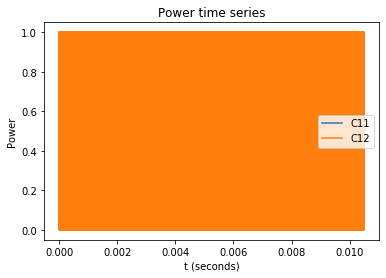

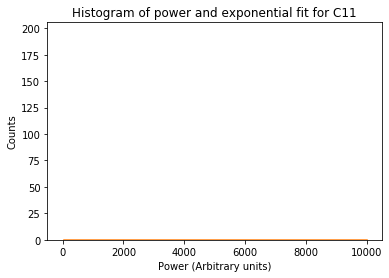

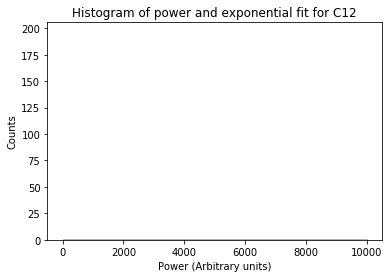

In [30]:
#Power series plot
plt.figure(3)
plt.plot(x,py1, label='C11')
plt.plot(x,py2, label='C12')
plt.xlabel('t (seconds)')
plt.ylabel('Power')
plt.title('Power time series')
plt.legend()
plt.show()

#Power Histogram C11
plt.figure(4)
plt.hist(p1,bins=hb,density=1)
plt.plot(xv2,w1)
plt.title('Histogram of power and exponential fit for C11')
plt.xlabel('Power (Arbitrary units)')
plt.ylabel('Counts')
plt.show()

#Power Histogram C12
plt.figure(5)
plt.hist(p2,bins=hb,density=1,label='AS')
plt.plot(xv2,w2,label='fit')
plt.title('Histogram of power and exponential fit for C12')
plt.xlabel('Power (Arbitrary units)')
plt.ylabel('Counts')
plt.show()


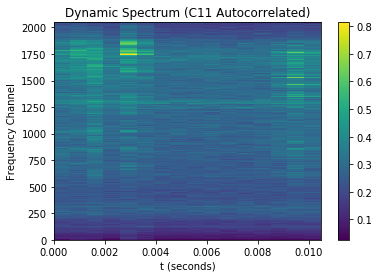

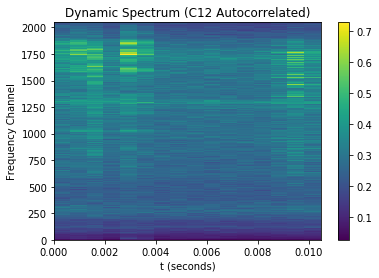

In [20]:
#Plotting Dynamic Spectrum
#C11 Autocorrelation
plt.figure(6)
plt.pcolor(xd,yd,fftt1)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 Autocorrelated)')
plt.show()

#C12 Autocorrelation
plt.figure(7)
plt.pcolor(xd,yd,fftt2)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C12 Autocorrelated)')
plt.show()



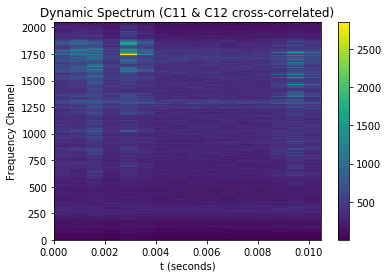

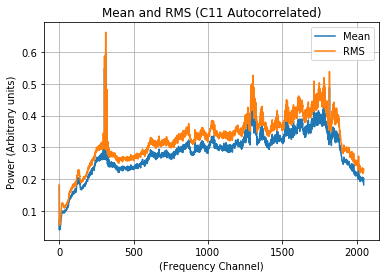

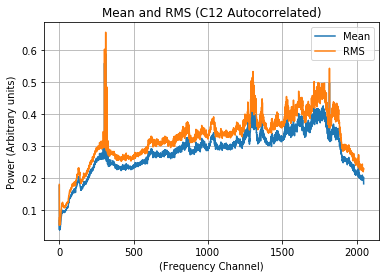

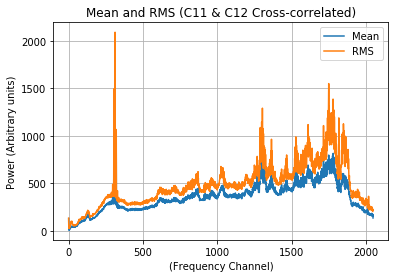

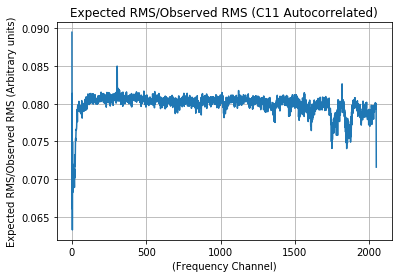

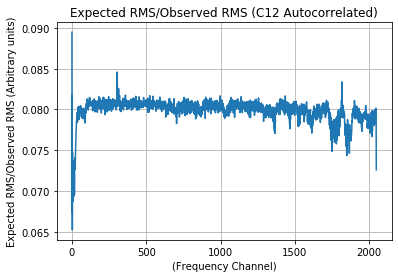

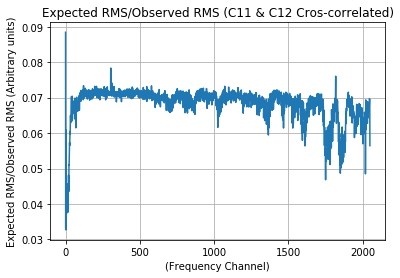

In [21]:
#Cross correlation AN & AS
plt.figure(8)
plt.pcolor(xd,yd,ffttc)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 & C12 cross-correlated)')
plt.show()

fm1 = np.zeros(np.shape(fft1)[0])
fr1 = np.zeros(np.shape(fft1)[0])
for i in range(int(np.shape(fft1)[0])):
    fm1[i]=np.mean(fft1[i])
    fr1[i]=sqrt(np.mean(np.square((fft1[i]))))

plt.figure(9)
plt.plot(yd,fm1,label='Mean')
plt.plot(yd,fr1,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fm2 = np.zeros(np.shape(fft2)[0])
fr2 = np.zeros(np.shape(fft2)[0])
for i in range(int(np.shape(fft2)[0])):
    fm2[i]=np.mean(fft2[i])
    fr2[i]=sqrt(np.mean(np.square((fft2[i]))))

plt.figure(10)
plt.plot(yd,fm2,label='Mean')
plt.plot(yd,fr2,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C12 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fmc = np.zeros(np.shape(fftc)[0])
frc = np.zeros(np.shape(fftc)[0])
for i in range(int(np.shape(fftc)[0])):
    fmc[i]=np.mean(fftc[i])
    frc[i]=sqrt(np.mean(np.square((fftc[i]))))

plt.figure(11)
plt.plot(yd,fmc,label='Mean')
plt.plot(yd,frc,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 & C12 Cross-correlated)')
plt.grid(True)
plt.legend()
plt.show()

fre1 = fm1/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
fre2 = fm2/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
frec = fmc/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))

plt.figure(12)
plt.plot(yd,fre1/fr1)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(13)
plt.plot(yd,fre2/fr2)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C12 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(14)
plt.plot(yd,frec/frc)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 & C12 Cros-correlated)')
plt.grid(True)
plt.show()


In [22]:
# Magnitude Consideration

#C11
y1 = np.abs(np.array(vl1.values.tolist()))#Voltage data
p1 = np.square(y1)#Power data
vy1 = y1[0:nv]
py1 = np.square(vy1)
m1 = np.mean(y1)#Mean
s1 = np.std(y1)#Standard deviation
y1 = y1 - m1#Correcting offset
a1 = np.reshape(y1,(Nt,Nfft))#2D array for input of fourier transform
ff1 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform


#C12
y2 = np.abs(np.array(vl2.values.tolist()))#voltage data
p2 = np.square(y2)#power data
vy2 = y2[0:nv]
py2 = np.square(vy2)
m2 = np.mean(y2)#Mean
s2 = np.std(y2)#Standard deviation
y2 = y2 - m2#Correcting offset
a2 = np.reshape(y2,(Nt,Nfft))#2D array for input of fourier transform
ff2 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Cross correlation (C11 & C12)
ffc = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Showing means and standard deviations
print("Mean for North Antenna:",m1)
print("Mean for South Antenna:",m2)
print("Standard deviation for North Antenna:",s1)
print("Standard deviation for South Antenna:",s2)

#Gaussian and exponential fit for histograms
xv = np.linspace(-100,100,num=hb)#voltage array
xv2 = np.linspace(0,10000,num=hb)#power array
z1 = (np.exp((-(xv)**2)/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1)#Gaussian fit for PD for north antenna
z2 = (np.exp((-(xv)**2)/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2)#Gaussian fit for PD for south antenna
w1 = (np.exp((-(xv2))/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1*(np.sqrt(xv2)))#Exponential fit for PD for north antenna
w2 = (np.exp((-(xv2))/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2*(np.sqrt(xv2)))#Exponential fit for PD for south antenna


Mean for North Antenna: 16.41347861289978
Mean for South Antenna: 16.452619791030884
Standard deviation for North Antenna: 13.749795978490585
Standard deviation for South Antenna: 13.82293338430518


C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [28]:
#Fourier Transform
for i in range(Nt):
    ft1 = np.fft.rfft(a1[i])#Fourier Transform (C11)
    ft2 = np.fft.rfft(a2[i])#Fourier Transform (C12)
    fts1 = ft1[1:np.shape(ft1)[0]]#Eliminating the zero frequency (C11)
    fts2 = ft2[1:np.shape(ft2)[0]]#Eliminating the zero frequency (C12)
    ff1[i]=np.abs(fts1)/n#Auto Correlation (C11)
    ff2[i]=np.abs(fts2)/n#Auto Correlation (C12)
    
    #Cross correlation
    o = np.conjugate(fts1)#Complex conjugate (C12)
    ftc = np.multiply(o,fts2)#Cross correlation (C11 & C12)
    ffc[i]=np.abs(ftc)/n#Taking magnitude

fft1 = np.transpose(ff1)
fft2 = np.transpose(ff2)
fftc = np.transpose(ffc)

#Averaging over time_res channels
time_res = 60#Number of time bins to be averaged
xt = int((np.shape(ff1)[0])/time_res)
yt = int(np.shape(ff1)[1])
ftf1 = np.zeros((xt,yt))#2D zero array for output (C11)
ftf2 = np.zeros((xt,yt))#2D zero array for output (C12)
ftfc = np.zeros((xt,yt))#2D zero array for real output (C11 & C12 cross correlation)
for i in range(xt):
    b1 = 0
    b2 = 0
    bc = 0
    for j in range(time_res):
        b1 = b1+ff1[j+(i*time_res)]
        b2 = b2+ff2[j+(i*time_res)]
        bc = bc+ffc[j+(i*time_res)]
    c1 = b1/time_res
    c2 = b2/time_res
    cc = bc/time_res
    ftf1[i]=c1
    ftf2[i]=c2
    ftfc[i]=cc
    
fftt1 = np.transpose(ftf1)
fftt2 = np.transpose(ftf2)
ffttc = np.transpose(ftfc)

xd = np.linspace(0,tt,num=int(Nt/time_res))
yd = np.linspace(0,Nf,num=Nf)

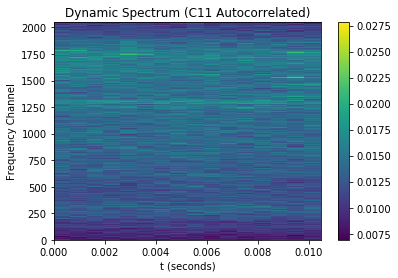

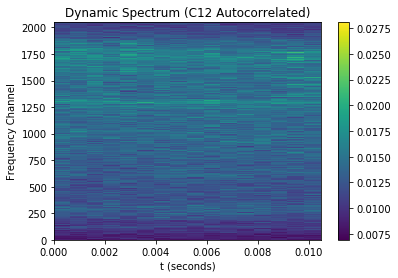

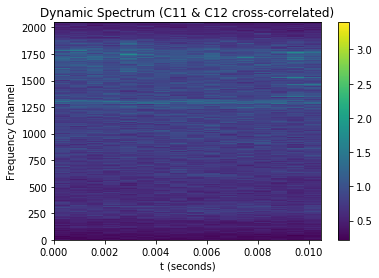

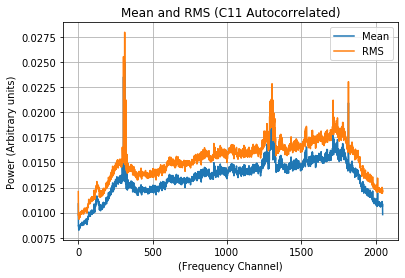

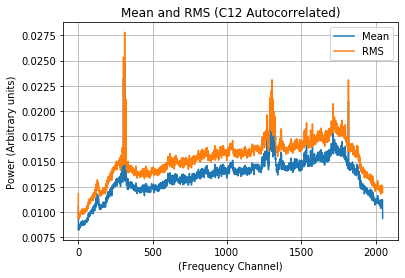

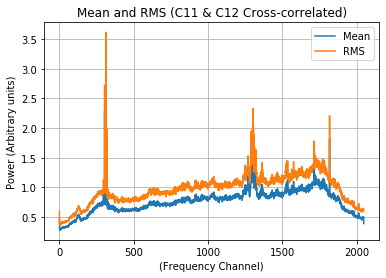

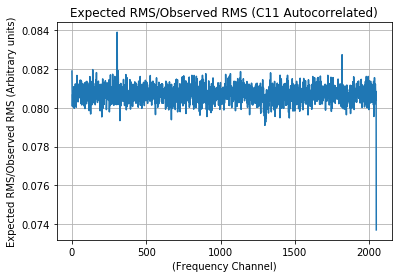

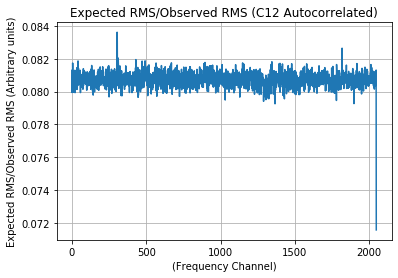

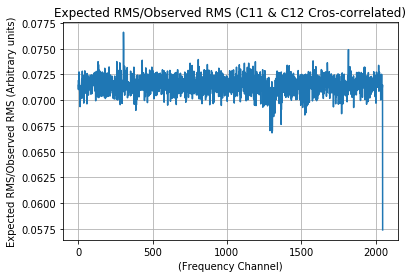

In [29]:
#Plotting Dynamic Spectrum
#C11 Autocorrelation
plt.figure(15)
plt.pcolor(xd,yd,fftt1)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 Autocorrelated)')
plt.show()

#C12 Autocorrelation
plt.figure(16)
plt.pcolor(xd,yd,fftt2)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C12 Autocorrelated)')
plt.show()

#Cross correlation AN & AS
plt.figure(17)
plt.pcolor(xd,yd,ffttc)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 & C12 cross-correlated)')
plt.show()

fm1 = np.zeros(np.shape(fft1)[0])
fr1 = np.zeros(np.shape(fft1)[0])
for i in range(int(np.shape(fft1)[0])):
    fm1[i]=np.mean(fft1[i])
    fr1[i]=sqrt(np.mean(np.square((fft1[i]))))

plt.figure(18)
plt.plot(yd,fm1,label='Mean')
plt.plot(yd,fr1,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fm2 = np.zeros(np.shape(fft2)[0])
fr2 = np.zeros(np.shape(fft2)[0])
for i in range(int(np.shape(fft2)[0])):
    fm2[i]=np.mean(fft2[i])
    fr2[i]=sqrt(np.mean(np.square((fft2[i]))))

plt.figure(19)
plt.plot(yd,fm2,label='Mean')
plt.plot(yd,fr2,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C12 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fmc = np.zeros(np.shape(fftc)[0])
frc = np.zeros(np.shape(fftc)[0])
for i in range(int(np.shape(fftc)[0])):
    fmc[i]=np.mean(fftc[i])
    frc[i]=sqrt(np.mean(np.square((fftc[i]))))
    

plt.figure(20)
plt.plot(yd,fmc,label='Mean')
plt.plot(yd,frc,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 & C12 Cross-correlated)')
plt.grid(True)
plt.legend()
plt.show()

fre1 = fm1/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
fre2 = fm2/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
frec = fmc/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))

plt.figure(21)
plt.plot(yd,fre1/fr1)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(22)
plt.plot(yd,fre2/fr2)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C12 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(23)
plt.plot(yd,frec/frc)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 & C12 Cros-correlated)')
plt.grid(True)
plt.show()


In [25]:
#Sign Consideration

#C11
y1 = np.sign(np.array(vl1.values.tolist()))#Voltage data
p1 = np.square(y1)#Power data
vy1 = y1[0:nv]
py1 = np.square(vy1)
m1 = np.mean(y1)#Mean
s1 = np.std(y1)#Standard deviation
y1 = y1 - m1#Correcting offset
a1 = np.reshape(y1,(Nt,Nfft))#2D array for input of fourier transform
ff1 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform


#C12
y2 = np.sign(np.array(vl2.values.tolist()))#voltage data
p2 = np.square(y2)#power data
vy2 = y2[0:nv]
py2 = np.square(vy2)
m2 = np.mean(y2)#Mean
s2 = np.std(y2)#Standard deviation
y2 = y2 - m2#Correcting offset
a2 = np.reshape(y2,(Nt,Nfft))#2D array for input of fourier transform
ff2 = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Cross correlation (C11 & C12)
ffc = np.zeros((Nt,Nf))#2D zero array for output of fourier transform

#Showing means and standard deviations
print("Mean for North Antenna:",m1)
print("Mean for South Antenna:",m2)
print("Standard deviation for North Antenna:",s1)
print("Standard deviation for South Antenna:",s2)

#Gaussian and exponential fit for histograms
xv = np.linspace(-100,100,num=hb)#voltage array
xv2 = np.linspace(0,10000,num=hb)#power array
z1 = (np.exp((-(xv)**2)/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1)#Gaussian fit for PD for north antenna
z2 = (np.exp((-(xv)**2)/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2)#Gaussian fit for PD for south antenna
w1 = (np.exp((-(xv2))/(2*(s1**2))))/(np.sqrt(2*np.pi)*s1*(np.sqrt(xv2)))#Exponential fit for PD for north antenna
w2 = (np.exp((-(xv2))/(2*(s2**2))))/(np.sqrt(2*np.pi)*s2*(np.sqrt(xv2)))#Exponential fit for PD for south antenna

#Fourier Transform
for i in range(Nt):
    ft1 = np.fft.rfft(a1[i])#Fourier Transform (C11)
    ft2 = np.fft.rfft(a2[i])#Fourier Transform (C12)
    fts1 = ft1[1:np.shape(ft1)[0]]#Eliminating the zero frequency (C11)
    fts2 = ft2[1:np.shape(ft2)[0]]#Eliminating the zero frequency (C12)
    ff1[i]=np.abs(fts1)/n#Auto Correlation (C11)
    ff2[i]=np.abs(fts2)/n#Auto Correlation (C12)
    
    #Cross correlation
    o = np.conjugate(fts1)#Complex conjugate (C12)
    ftc = np.multiply(o,fts2)#Cross correlation (C11 & C12)
    ffc[i]=np.abs(ftc)/n#Taking magnitude

fft1 = np.transpose(ff1)
fft2 = np.transpose(ff2)
fftc = np.transpose(ffc)

#Averaging over time_res channels
time_res = 60#Number of time bins to be averaged
xt = int((np.shape(ff1)[0])/time_res)
yt = int(np.shape(ff1)[1])
ftf1 = np.zeros((xt,yt))#2D zero array for output (C11)
ftf2 = np.zeros((xt,yt))#2D zero array for output (C12)
ftfc = np.zeros((xt,yt))#2D zero array for real output (C11 & C12 cross correlation)
for i in range(xt):
    b1 = 0
    b2 = 0
    bc = 0
    for j in range(time_res):
        b1 = b1+ff1[j+(i*time_res)]
        b2 = b2+ff2[j+(i*time_res)]
        bc = bc+ffc[j+(i*time_res)]
    c1 = b1/time_res
    c2 = b2/time_res
    cc = bc/time_res
    ftf1[i]=c1
    ftf2[i]=c2
    ftfc[i]=cc
    
fftt1 = np.transpose(ftf1)
fftt2 = np.transpose(ftf2)
ffttc = np.transpose(ftfc)

xd = np.linspace(0,tt,num=int(Nt/time_res))
yd = np.linspace(0,Nf,num=Nf)



Mean for North Antenna: -0.04131817817687988
Mean for South Antenna: -0.040508270263671875
Standard deviation for North Antenna: 0.988636362367644
Standard deviation for South Antenna: 0.9886552888826105


C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\parvp\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


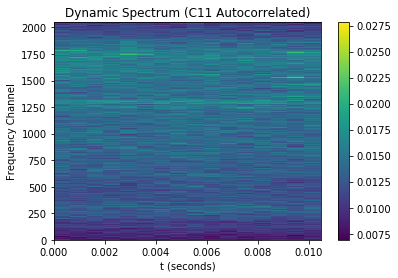

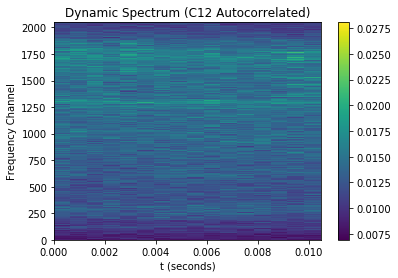

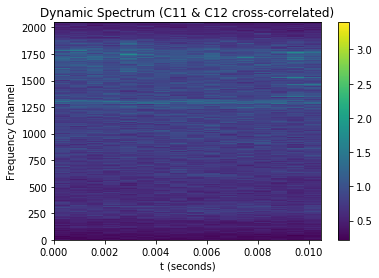

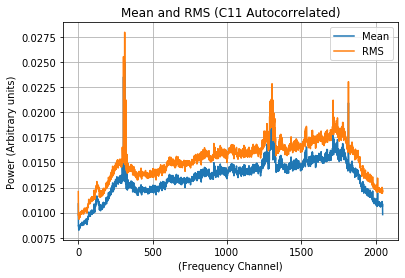

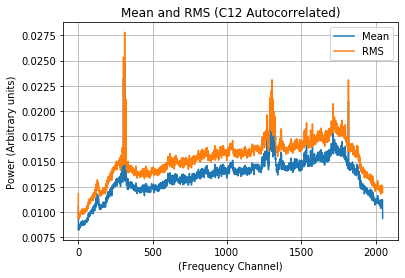

In [26]:
#Plotting Dynamic Spectrum
#C11 Autocorrelation
plt.figure(24)
plt.pcolor(xd,yd,fftt1)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 Autocorrelated)')
plt.show()

#C12 Autocorrelation
plt.figure(25)
plt.pcolor(xd,yd,fftt2)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C12 Autocorrelated)')
plt.show()

#Cross correlation AN & AS
plt.figure(26)
plt.pcolor(xd,yd,ffttc)
plt.colorbar()
plt.xlabel('t (seconds)')
plt.ylabel('Frequency Channel')
plt.title('Dynamic Spectrum (C11 & C12 cross-correlated)')
plt.show()

fm1 = np.zeros(np.shape(fft1)[0])
fr1 = np.zeros(np.shape(fft1)[0])
for i in range(int(np.shape(fft1)[0])):
    fm1[i]=np.mean(fft1[i])
    fr1[i]=sqrt(np.mean(np.square((fft1[i]))))

plt.figure(27)
plt.plot(yd,fm1,label='Mean')
plt.plot(yd,fr1,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fm2 = np.zeros(np.shape(fft2)[0])
fr2 = np.zeros(np.shape(fft2)[0])
for i in range(int(np.shape(fft2)[0])):
    fm2[i]=np.mean(fft2[i])
    fr2[i]=sqrt(np.mean(np.square((fft2[i]))))

plt.figure(28)
plt.plot(yd,fm2,label='Mean')
plt.plot(yd,fr2,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C12 Autocorrelated)')
plt.grid(True)
plt.legend()
plt.show()

fmc = np.zeros(np.shape(fftc)[0])
frc = np.zeros(np.shape(fftc)[0])
for i in range(int(np.shape(fftc)[0])):
    fmc[i]=np.mean(fftc[i])
    frc[i]=sqrt(np.mean(np.square((fftc[i]))))


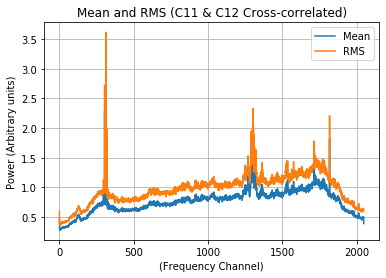

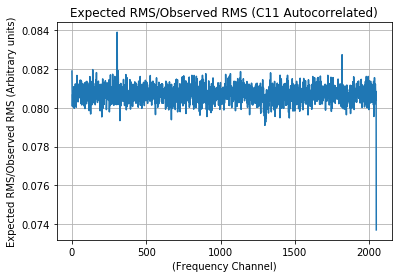

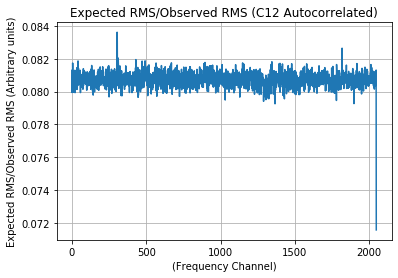

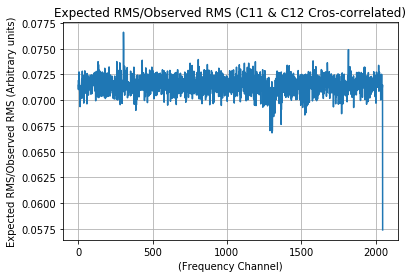

In [27]:
plt.figure(29)
plt.plot(yd,fmc,label='Mean')
plt.plot(yd,frc,label='RMS')
plt.xlabel('(Frequency Channel)')
plt.ylabel('Power (Arbitrary units)')
plt.title('Mean and RMS (C11 & C12 Cross-correlated)')
plt.grid(True)
plt.legend()
plt.show()

fre1 = fm1/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
fre2 = fm2/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))
frec = fmc/sqrt(2*(tt/np.shape(xd)[0])*(fmax/Nf))

plt.figure(30)
plt.plot(yd,fre1/fr1)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(31)
plt.plot(yd,fre2/fr2)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C12 Autocorrelated)')
plt.grid(True)
plt.show()

plt.figure(32)
plt.plot(yd,frec/frc)
plt.xlabel('(Frequency Channel)')
plt.ylabel('Expected RMS/Observed RMS (Arbitrary units)')
plt.title('Expected RMS/Observed RMS (C11 & C12 Cros-correlated)')
plt.grid(True)
plt.show()